In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [2]:
# This notebook is to practice plotting information about the fitting 
# process for regressions or classifications.  I am not trying to train the 
# most accurate models for this notebook.

# Regression
# plot the error for different hyperparameters
# plot the error vs number of variables included if selecting manually

# Classification
# plot the accuracy for different hyperparameters
# plot the roc curve
# plot the accuracy vs number of variables if selecting manually
# create a confusion matrix

# For regression and classification, we can plot the effect of training set
# size on cross validation score using learning curves

# You can also plot fit times vs different parameter values, but I will not
# be practicing that with these datasets

In [3]:
# First I will practice with a regression on the California Housing dataset

# Load the data
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [4]:
# Standard scale the datasets and put them back into dataframes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
train_names = scaler.get_feature_names_out()
X_test_scaled = scaler.fit_transform(X_test)
test_names = scaler.get_feature_names_out()
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=train_names)
X_test_scaled_df = pd.DataFrame(data=X_test_scaled, columns=test_names)

In [5]:
# Using grid search to determine the optimal value of alpha for the lasso 
# regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

scoring = {"mae":make_scorer(mean_absolute_error), 
           "r2":make_scorer(r2_score)}

clf = GridSearchCV(
    Lasso(), 
    return_train_score=True, 
    param_grid = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]},
    scoring=scoring, 
    refit="mae")

In [6]:
clf.fit(X_train_scaled_df, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]},
             refit='mae', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error),
                      'r2': make_scorer(r2_score)})

In [7]:
# This is selecting alpha = 1 to be the best estimator.  Lets see if we 
# agree with this.
clf.best_estimator_.alpha

1.0

In [8]:
# Extracting the train and test mae for each alpha value
train_absolute_errors = clf.cv_results_["mean_train_mae"]
test_absolute_errors = clf.cv_results_["mean_test_mae"]

# Extracting the train and test r2 scores for each alpha value
train_r2_averages = clf.cv_results_["mean_train_r2"]
test_r2_averages = clf.cv_results_["mean_test_r2"]

In [9]:
alpha = list()
for param in clf.cv_results_["params"]:
    alpha.append(list(param.values())[0])

In [10]:
import matplotlib.pyplot as plt

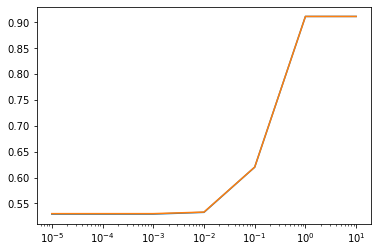

In [11]:
# Plotting the train mae vs the test mae for different levels of alpha.
# We would expect the test mae to be higher at each point, but 
# that is not the case for some reason.  Visually, they overlap completely 
# but the values at each alpha level are not exactly the same.

# It looks like log 10^-2 will be the alpha which yields good accuracy and
# is as simple as possible.

# The fact that the test mae and train mae overlap are so similar points to 
# a possible error.
plt.plot(alpha, train_absolute_errors, alpha, test_absolute_errors)
plt.semilogx()
plt.show()

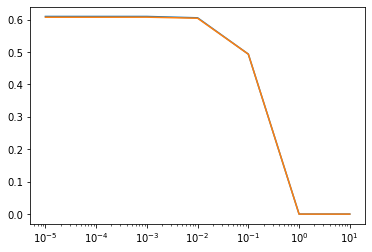

In [12]:
plt.plot(alpha, train_r2_averages, alpha, test_r2_averages)
plt.semilogx()
plt.show()

In [13]:
# Now we see why the test errors and train errors are very similar for each
clf.best_estimator_.coef_

array([ 0.,  0.,  0., -0., -0., -0., -0., -0.])

In [14]:
clf.best_estimator_.intercept_

2.0666362048018514

In [15]:
# Testing the mae when alpha is set to 0.01.  This is the largest alpha 
# before mae starts increasing and r2 starts decreasing.
lasso_custom = Lasso(alpha=0.01)
lasso_custom.fit(X_train_scaled_df, y_train)
y_pred_custom = lasso_custom.predict(X_test_scaled_df)
mean_absolute_error(y_pred_custom, y_test)

0.5296069635104079

In [16]:
lasso_custom.coef_

array([ 0.79296204,  0.12425208, -0.16249723,  0.20902305,  0.        ,
       -0.03116597, -0.78933429, -0.75764998])

In [17]:
lasso_custom.intercept_

2.0666362048018536

In [18]:
# Testing the mae when alpha is set to 1 as the grid search decided.
# This is significantly less accurate than the lasso with alpha = 0.01
y_pred_grid = clf.predict(X_test_scaled_df)
mean_absolute_error(y_pred_grid, y_test)

0.9126511897647483

In [19]:
# Now, I will train a lasso with the sklearn built in cv to compare my
# results.

# These coefficients are very similar to the coefficients for the lasso
# with alpha=0.01
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_train_scaled_df, y_train)
reg.coef_

array([ 0.83368779,  0.12132073, -0.26590159,  0.31384733,  0.        ,
       -0.03917308, -0.8687081 , -0.84285433])

In [20]:
# This outputs a similar intercept to the other two lassos
reg.intercept_

2.0666362048018536

In [21]:
# lassoCV has slightly lower mae than the lasso with alpha = 0.01
reg_pred = reg.predict(X_test_scaled_df)
mean_absolute_error(reg_pred, y_test)

0.5260326193846283

In [22]:
# This regressor chose an alpha that was relatively close on the log scale
# to the the alpha I chose through graph inspection.
reg.alpha_

0.0024252843132217634

In [23]:
# Lets look at how the size of the dataset may have effected our results

# First, we standard scale the entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_names = scaler.get_feature_names_out()
X_scaled_df = pd.DataFrame(X_scaled, columns=X_names)

In [24]:
# using the learning curve function on the entire dataset
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    LassoCV(), X_scaled_df, y, cv=5)

In [25]:
# extracting the average train scores at each training size
scores = list()
for sample in train_scores:
    scores.append(np.mean(sample))

In [26]:
# extracting the average val scores at each training size
val_scores = list()
for sample in valid_scores:
    val_scores.append(np.mean(sample))

In [27]:
# Setting val_score[0] to np.nan, because it is an outlier the would hinder 
# visualizing the rest of the plot
val_scores[0] = np.nan

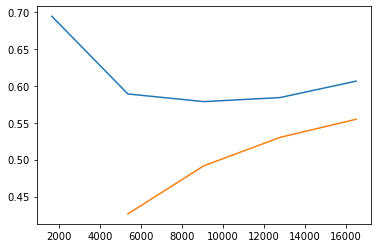

In [28]:
# Here we have graphed average cv training and validation score vs training
# set size.

# Blue is train, orange is val.  Our training set was just under 14000.
# We see that increasing our train size would only help improve the fit, 
# but we would likely have to consider using polynomial variables or 
# combination variables if we wanted to improve the results.
plt.plot(train_sizes, scores, train_sizes, val_scores)

In [29]:
# Now, I will practice plotting techniques used to visualize the 
# classification process

In [30]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [31]:
# Scaling the data using standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
clf = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={"n_neighbors":[3,4,5,6,7,8,9,10]},
    return_train_score=True,
    scoring=["accuracy", "roc_auc_ovr"],
    refit="accuracy"
)
clf.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'roc_auc_ovr'])

In [33]:
clf.score(X_test_scaled, y_test)

0.9661016949152542

In [34]:
clf.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [35]:
# Accessing grid search results to get plotting information
n_neighbors = clf.cv_results_["param_n_neighbors"].__array__()
train_score = clf.cv_results_["mean_train_accuracy"]
test_score = clf.cv_results_["mean_test_accuracy"]

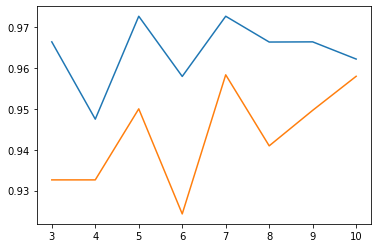

In [36]:
# Blue is train score, orange is test score.  I would expect this graph to 
# be more smooth in a dataset with more training examples.  
plt.plot(n_neighbors, train_score, n_neighbors, test_score)

In [37]:
# I can also plot the roc_auc

# extracting mean auc values from grid search
train_mean_auc = clf.cv_results_["mean_train_roc_auc_ovr"]
test_mean_auc = clf.cv_results_["mean_test_roc_auc_ovr"]

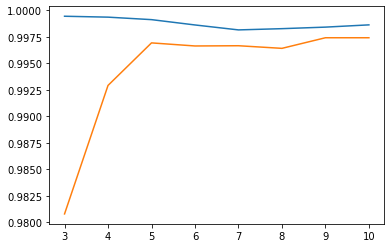

In [38]:
# Plotting the values. Cross validation train set mean roc auc is blue, and 
# cross validation test set mean roc auc is orange.  This plot would suggest 
# 5 neighbors is the lowest we can go before we start to see meaningful
# decrease in performance.
plt.plot(n_neighbors, train_mean_auc,n_neighbors, test_mean_auc)

In [39]:
# If we train a model with n_neighbors = 5, our accuracy is 94.9% on the 
# test set.  This is not much worse than the model we selected using 
# accuracy.  I also ran the grid search initially with n_neighbors ranging
# all the way up to 13, and the grid search selected a model with 11 
# neighbors as the model to refit with.  That model scored 91% on the test
# set, so it is clear that accuracy may have only selected the better model
# due to luck and the small size of the dataset.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9491525423728814

In [40]:
# I could plot the roc auc curve at different levels of n_neighbors if I was
# interested.  However, plotting roc_auc for multiclass is a bit of a pain, I will leave this to
# try at a later date
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multiclass-problem

In [41]:
# I could also plot this using sklearn validation curves
from sklearn.model_selection import validation_curve
param_range = [3,4,5,6,7,8,9,10]
train_scores_curve, test_scores_curve = validation_curve(
    KNeighborsClassifier(),
    X_train_scaled,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="accuracy"
)

In [42]:
# calculating the mean train and test score at each nneighbors value.
# I could calculate std to enhance the graph, but not going to bother.
train_means = np.mean(train_scores_curve, axis=1)
test_means = np.mean(test_scores_curve, axis=1)

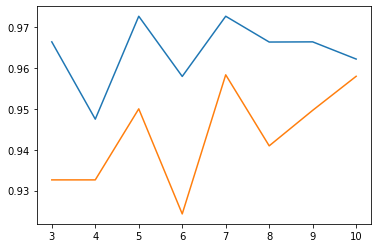

In [43]:
# Here is the final graph, exactly the same as before.  Having tried both,
# I think that I would rather train a grid search because it automatically
# calculates all the means and stds I would need to generate the graph.
plt.plot(param_range, train_means, param_range, test_means)